In [68]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [69]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

# Measuring fairness - Metric convergence

In [39]:
# setup helper for generating experiments (basically all sets of params to run through sim)
def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))

columns=[
    "electorate_size",
    "clusters",
    "cluster_std" 
    "issues",
    "candidates",
    "electoral_system",
    "apathy_prob",
    "fairness"
]

experiments = {
    "electorate_size": [10_000],
    "clusters": [10],
    "cluster_std": [1],
    "electoral_system": ["plurality", "majority"],
    "apathy_prob": [0.0],
    "candidates": [2],
    "issues": [2],
}

records = []
columns = [*experiments.keys(), "fairness", "t"]
experiment_matrix = list(generate_experiment_matrix(experiments))


# outer monte carlo sim
for _ in tqdm(range(10_000)):
    for params in experiment_matrix:

        # setup objects
        voters = electorate.setup_electorate(**params)
        parties = candidates.setup_candidates(**params, electorate=voters)
        system = voting_system.setup_voting_system(name=params["electoral_system"], **params)

        # simulate elections
        sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())

        result = sim.run()
        result_record = { "fairness": round(result.measured_fairness, 3), **params }
        result_record = {k: v for k, v in result_record.items() if k in columns}
        records.append(result_record)

100%|██████████████████████████████████████████| 10000/10000 [14:43<00:00, 11.31it/s]


In [86]:
results_df = pd.DataFrame.from_records(records)
results_df.head()

,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues
0,0.941,10000,10,1,plurality,0.0,2,2
1,0.907,10000,10,1,majority,0.0,2,2
2,0.973,10000,10,1,plurality,0.0,2,2
3,0.925,10000,10,1,majority,0.0,2,2
4,0.910,10000,10,1,plurality,0.0,2,2


In [44]:
# stoe away so we don't need to rerun experiment
# filepath = "data/fairness-convergence-a91ed7aa-b6f6-4a85-9ccf-eeb37ea9da02.csv"
# assert not os.path.isfile(filepath), "data export already exists. Use a new uuid to prevent overwriting"
# results_df.to_csv(filepath, index=False)

AssertionError: data export already exists. Use a new uuid to prevent overwriting

In [90]:
results_df

,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,avg_fairness
0,0.941,10000,10,1,plurality,0.0,2,2,0
1,0.907,10000,10,1,majority,0.0,2,2,0
2,0.973,10000,10,1,plurality,0.0,2,2,0
3,0.925,10000,10,1,majority,0.0,2,2,0
4,0.910,10000,10,1,plurality,0.0,2,2,0
...,...,...,...,...,...,...,...,...,...
19995,0.849,10000,10,1,majority,0.0,2,2,0
19996,0.801,10000,10,1,plurality,0.0,2,2,0
19997,0.850,10000,10,1,majority,0.0,2,2,0
19998,0.858,10000,10,1,plurality,0.0,2,2,0


In [87]:
# calculate cumulative averages for each electoral system
majority = results_df.electoral_system == "majority"
plurality = results_df.electoral_system == "plurality"

In [123]:
majority_df = results_df[majority].reset_index().drop(["index"], axis=1).reset_index()
plurality_df = results_df[plurality].reset_index().drop(["index"], axis=1).reset_index()

# use datetime index to enable timeseries plotting
majority_df["t"] = majority_df.index + 1
plurality_df["t"] = plurality_df.index + 1

In [124]:
majority_df.head()

,index,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,avg_fairness,t
0,0,0.907,10000,10,1,majority,0.0,2,2,0,1
1,1,0.925,10000,10,1,majority,0.0,2,2,0,2
2,2,0.952,10000,10,1,majority,0.0,2,2,0,3
3,3,0.922,10000,10,1,majority,0.0,2,2,0,4
4,4,0.850,10000,10,1,majority,0.0,2,2,0,5


In [130]:
majority_df

,index,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,avg_fairness,t
0,0,0.907,10000,10,1,majority,0.0,2,2,0.907000,1
1,1,0.925,10000,10,1,majority,0.0,2,2,0.462500,2
2,2,0.952,10000,10,1,majority,0.0,2,2,0.317333,3
3,3,0.922,10000,10,1,majority,0.0,2,2,0.230500,4
4,4,0.850,10000,10,1,majority,0.0,2,2,0.170000,5
...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.952,10000,10,1,majority,0.0,2,2,0.000095,9996
9996,9996,0.947,10000,10,1,majority,0.0,2,2,0.000095,9997
9997,9997,0.849,10000,10,1,majority,0.0,2,2,0.000085,9998
9998,9998,0.850,10000,10,1,majority,0.0,2,2,0.000085,9999


In [131]:
# set avg fairness
majority_df.loc[:, "avg_fairness"] = majority_df["fairness"].cumsum() / majority_df.t 
plurality_df.loc[:, "avg_fairness"] = plurality_df["fairness"].cumsum() / plurality_df.t 

In [135]:
majority_df[majority_df.avg_fairness == 0]

,index,fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,avg_fairness,t


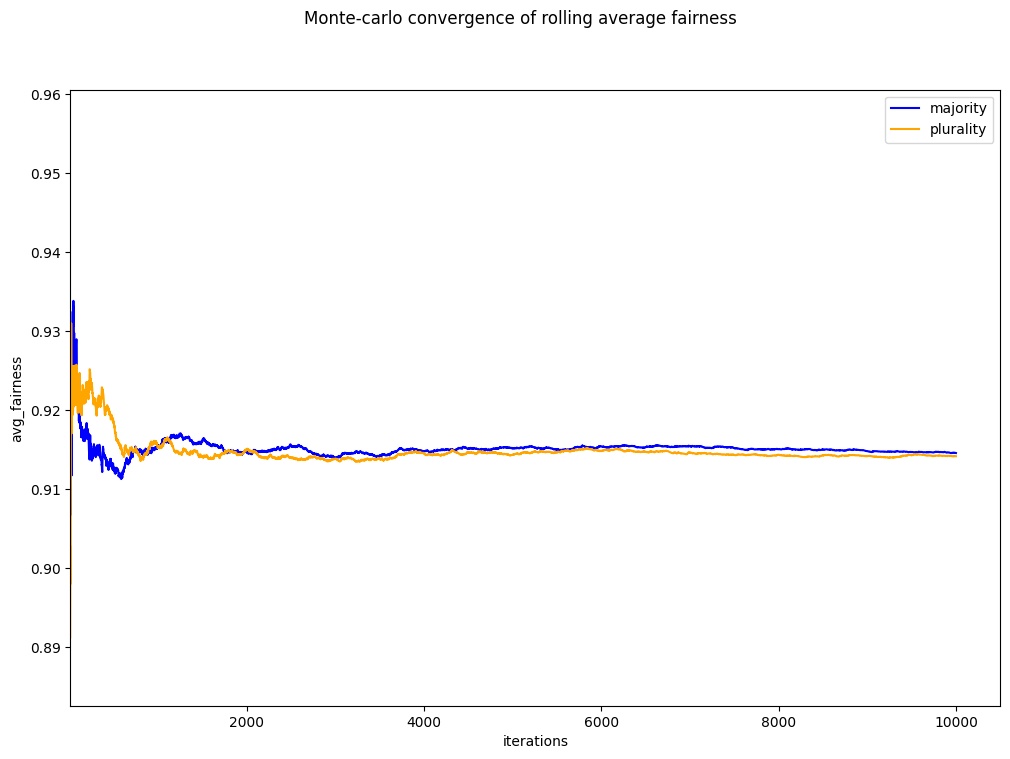

In [149]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))
sns.lineplot(data=majority_df, x="t", y="avg_fairness", color="blue", label="majority" , ax=ax)
sns.lineplot(data=plurality_df, x="t", y="avg_fairness", color="orange", label="plurality", ax=ax)
ax.set_xlim(10,) # just for polish
ax.set_xlabel("iterations (t)")
plt.suptitle("Monte-carlo convergence of rolling average fairness")
plt.show()